In [1]:
%reset

##### Copyright 2020 Kyu Sang Han

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, MaxPool2D, Flatten, GlobalAveragePooling2D, add,average,maximum
from tensorflow_docs import modeling
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib
import shutil
tfds.disable_progress_bar() # disable tqdm progress bar

In [3]:
print("TensorFlow Version: ",tf.__version__)
print("Number of GPU available: ",len(tf.config.experimental.list_physical_devices("GPU")))

TensorFlow Version:  2.1.0
Number of GPU available:  2


In [4]:
def read_and_label(file_path):
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  label = get_label(file_path)
  return img, label

def decode_img(img):
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  return tf.reshape(tf.where(parts[-4] == CLASS_NAMES),[])

def augment(image,label):
  image = tf.image.random_hue(image, max_delta=0.05, seed=5)
  image = tf.image.random_contrast(image, 0.95, 1.05, seed=5) # tissue quality
  image = tf.image.random_saturation(image, 0.95, 1.05, seed=5) # stain quality
  image = tf.image.random_brightness(image, max_delta=0.05) # tissue thickness, glass transparency (clean)
  image = tf.image.random_flip_left_right(image, seed=5) # cell orientation
  image = tf.image.random_flip_up_down(image, seed=5) # cell orientation
  image = tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)) # cell orientation
  return image,label

In [5]:
IMG_HEIGHT = 100
IMG_WIDTH = 100
BATCH_SIZE = 32
val_fraction = 10
# list location of all training images
data_dir=r'C:\Users\kuki\Desktop\Research\Skin\RCNN data\train'
data_dir = pathlib.Path(data_dir)
train_image_count = len(list(data_dir.glob('*\*\image\*.jpg')))
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt" and item.name != ".DS_store"])
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*/image/*'))
AUTOTUNE = tf.data.experimental.AUTOTUNE
labeled_ds = list_ds.map(read_and_label, num_parallel_calls=AUTOTUNE)
# plt.figure(figsize=(10,10))
# for idx,elem in enumerate(labeled_ds.take(25)):
#     img = elem[0]
#     label = elem[1]
#     ax = plt.subplot(5,5,idx+1)
#     plt.imshow(img)
#     plt.title(CLASS_NAMES[label].title())
#     plt.axis('off')

In [6]:
test_data_dir=r'C:\Users\kuki\Desktop\Research\Skin\RCNN data\test'
test_data_dir = pathlib.Path(test_data_dir)
test_image_count = len(list(test_data_dir.glob('*\*\image\*.jpg')))
test_list_ds = tf.data.Dataset.list_files(str(test_data_dir/'*\*\image\*'))
test_labeled_ds = test_list_ds.map(read_and_label, num_parallel_calls=AUTOTUNE)

val_image_count = test_image_count//100 * val_fraction # // : floor division ex) 15/2 = 7.5 -> 7
test_image_count2 = test_image_count - val_image_count
STEPS_PER_EPOCH = train_image_count//BATCH_SIZE
TEST_STEPS = test_image_count2 // BATCH_SIZE
VALIDATION_STEPS = val_image_count // BATCH_SIZE

In [7]:
shuffle_buffer_size = 3000 #take first 100 from dataset and shuffle and pick one.
train_ds = (labeled_ds
#             .skip(val_image_count)
            .cache("./cache/fibro_train.tfcache")
            .shuffle(buffer_size=shuffle_buffer_size)
            .repeat()
            .batch(BATCH_SIZE)
            .map(augment, num_parallel_calls=AUTOTUNE) #always batch before mapping
            .prefetch(buffer_size=AUTOTUNE) 
            )

# no shuffle, augment for validation and test dataset
val_ds= (test_labeled_ds
               .shuffle(buffer_size=shuffle_buffer_size)
               .take(val_image_count)
               .cache("./cache/fibro_val.tfcache")
               .repeat()
               .batch(BATCH_SIZE)
               .prefetch(buffer_size=AUTOTUNE))

test_ds = (test_labeled_ds
            .cache("./cache/fibro_test.tfcache")
            .repeat()
            .batch(BATCH_SIZE)
            .prefetch(buffer_size=AUTOTUNE) #time it takes to produce next element
            )

In [8]:
mirrored_strategy = tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [9]:
with mirrored_strategy.scope():
    model_cnnA= Sequential([
                    Conv2D(16, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)
                           ,kernel_initializer='he_uniform',kernel_regularizer=tf.keras.regularizers.l2(0.001)),
                    MaxPool2D((2, 2)),
                    Dropout(0.5),
                    Conv2D(32, (3, 3), activation='relu',
                           kernel_initializer='he_uniform',kernel_regularizer=tf.keras.regularizers.l2(0.001)),
                    MaxPool2D((2, 2)),
                    Conv2D(64, (3, 3), activation='relu',
                           kernel_initializer='he_uniform',kernel_regularizer=tf.keras.regularizers.l2(0.001)),
                    Dropout(0.5),
                    Flatten(),
                    Dense(512, activation='relu',
                           kernel_initializer='he_uniform',kernel_regularizer=tf.keras.regularizers.l2(0.001)),
                    Dense(2)
                ])
    model_cnnA.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
          metrics=['accuracy'])

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


In [10]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
shutil.rmtree(checkpoint_dir, ignore_errors=True)

def get_callbacks(name):
  return [
    modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                     patience=500,restore_best_weights=True),
#     tf.keras.callbacks.TensorBoard(log_dir/name, histogram_freq=1),
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                       verbose=0,
                                       monitor='val_loss',
                                       save_weights_only=True,
                                       save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                         factor=0.1, patience=10, verbose=0, mode='auto',
                                         min_delta=0.0001, cooldown=0, min_lr=0),
  ]

In [11]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.0001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

In [23]:
def compilefit(model, name, optimizer=None, max_epochs=2):
#     optimizer = optimizers.Adam(lr_schedule)
    model_history = model.fit(train_ds,
          steps_per_epoch= STEPS_PER_EPOCH,
          epochs=max_epochs,
          verbose=2,
          validation_data=val_ds,
          callbacks=get_callbacks(name),
          validation_steps=VALIDATION_STEPS,
          use_multiprocessing=True
                       )
    if not os.path.isdir(os.path.abspath(name)):
        os.mkdir(os.path.abspath(name))
    model.save(pathlib.Path(name)/'full_model.h5')
    return model_history

In [19]:
def plotdf(dfobj,condition):
    dfobj1=dfobj.copy()
    dfobj2=dfobj.copy()
    dfobj3=dfobj.copy()
    dfobj1.pop('lr')
    dfobj1.pop('loss')
    dfobj1.pop('val_loss')
    pd.DataFrame(dfobj1).plot(title=condition)
    dfobj2.pop('lr')
    dfobj2.pop('accuracy')
    dfobj2.pop('val_accuracy')
    pd.DataFrame(dfobj2).plot()
    dfobj3.pop('loss')
    dfobj3.pop('val_loss')
    dfobj3.pop('accuracy')
    dfobj3.pop('val_accuracy')
    pd.DataFrame(dfobj3).plot()

In [14]:
histories={}

In [15]:
histories['cnnA'] = compilefit(model_cnnA,'cnn/A')
plotdf(histories['cnnA'].history,'7 layer CNN with initializer&normalizer')
results = model_cnnA.evaluate(test_ds,steps=TEST_STEPS)
print('test loss, test acc:', results)
#62

Train for 222 steps, validate for 2 steps
Epoch 1/10
INFO:tensorflow:batch_all_reduce: 10 all-reduces with algorithm = hierarchical_copy, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 10 all-reduces with algorithm = hierarchical_copy, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0

KeyError: 'sparse_categorical_crossentropy'

In [21]:
with mirrored_strategy.scope():
    inputs = tf.keras.Input(shape=(100, 100, 3), name='img')
    x = Conv2D(32, 3, activation='relu',kernel_initializer='he_uniform')(inputs)
    x = Conv2D(64, 3, activation='relu',kernel_initializer='he_uniform')(x)
    block_1_output = MaxPool2D(3)(x)

    x = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_uniform')(block_1_output)
    x = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_uniform')(x)
    block_2_output = add([x, block_1_output])

    x = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_uniform')(block_2_output)
    x = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_uniform')(x)
    block_3_output = add([x, block_2_output])

    x = Conv2D(64, 3, activation='relu',kernel_initializer='he_uniform')(block_3_output)
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu',kernel_initializer='he_uniform')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(2)(x)

    model_cnnB = tf.keras.Model(inputs, outputs, name='toy_resnet')
    model_cnnB.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=['accuracy'])


Train for 222 steps, validate for 2 steps
Epoch 1/10
INFO:tensorflow:batch_all_reduce: 18 all-reduces with algorithm = hierarchical_copy, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:batch_all_reduce: 18 all-reduces with algorithm = hierarchical_copy, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10

Epoch: 0, accuracy:0.7931,  loss:0.5061,  val_accuracy:0.7812,  val_loss:0.3784,  
.222/222 - 8s - loss: 0.5061 - accuracy: 0.7931 - val_loss: 0.3784 - val_accuracy: 0.7812
Epoch 2/10
.222/222 - 3s - loss: 0.3946 - accuracy: 0.8366 - val_loss: 0.3958 - val_accuracy: 0.7969
Epoch 3/10
.222/222 - 4s - loss: 0.3170 - accuracy: 0.8764 - val_loss: 0.2863 - val_accuracy: 0.8906
Epoch 4/10
.222/222 - 4s - loss: 0.2404 - accuracy: 0.9093 - val_loss: 0.1592 - val_accuracy: 0.9375
Epoch 5/10
.222/222 - 4s - loss: 0.2233 - accuracy: 0.9169 - val_loss: 0.1267 - val_accuracy: 0.9688
Epoch 6/10
.222/222 - 4s - loss: 0.1750

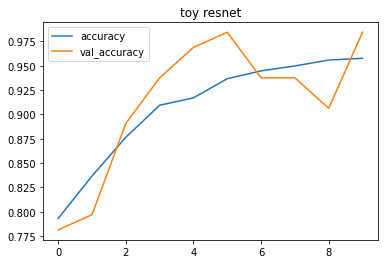

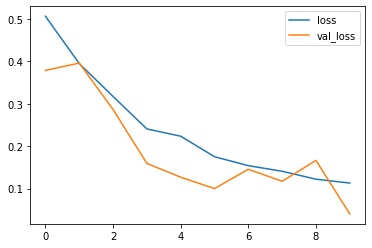

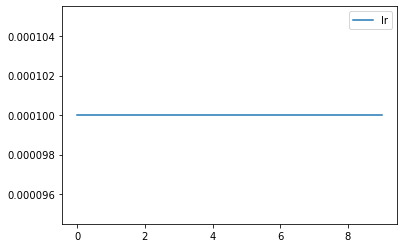

In [22]:
histories['cnnB'] = compilefit(model_cnnB,'cnn/B')
plotdf(histories['cnnB'].history,'toy resnet')
results = model_cnnB.evaluate(test_ds,steps=TEST_STEPS)
print('test loss, test acc:', results)
#80

In [24]:
with mirrored_strategy.scope():
    mobilenetv2 = tf.keras.Sequential([
        hub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v2_101/feature_vector/4",
                       trainable=False),  # Can be True, see below.
        tf.keras.layers.Dense(2, activation='softmax')
    ])
    mobilenetv2.build([None, 100, 100, 3])  # Batch input shape.
    mobilenetv2.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
          metrics=['accuracy'])

Train for 222 steps, validate for 2 steps
Epoch 1/2
INFO:tensorflow:batch_all_reduce: 2 all-reduces with algorithm = hierarchical_copy, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:batch_all_reduce: 2 all-reduces with algorithm = hierarchical_copy, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10

Epoch: 0, accuracy:0.7838,  loss:0.5310,  val_accuracy:0.7500,  val_loss:0.5600,  
.222/222 - 18s - loss: 0.5310 - accuracy: 0.7838 - val_loss: 0.5600 - val_accuracy: 0.7500
Epoch 2/2
.222/222 - 7s - loss: 0.4996 - accuracy: 0.8110 - val_loss: 0.4957 - val_accuracy: 0.8281
27/27 [==============================] - 4s 133ms/step - loss: 0.8735 - accuracy: 0.3461

INFO:tensorflow:batch_all_reduce: 2 all-reduces with algorithm = hierarchical_copy, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:batch_all_reduce: 2 all-reduces with algorithm = hierarchical_copy, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10


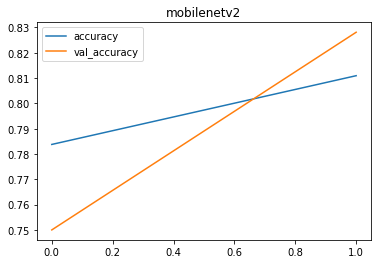

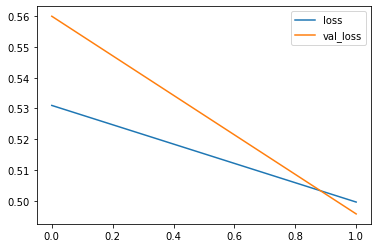

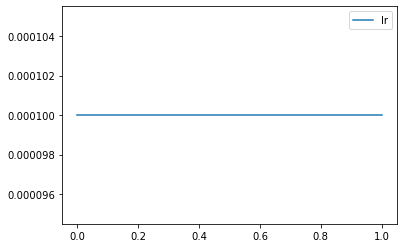

In [25]:
histories['mobilenetv2'] = compilefit(mobilenetv2,'cnn/mobilenetv2')
plotdf(histories['mobilenetv2'].history,'mobilenetv2')
results = mobilenetv2.evaluate(test_ds,steps=TEST_STEPS)
print('test loss, test acc:', results)
#80

In [26]:
with mirrored_strategy.scope():
    mobilenetv2_train = tf.keras.Sequential([
        hub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v2_101/feature_vector/4",
                       trainable=True),  # Can be True, see below.
        tf.keras.layers.Dense(2, activation='softmax')
    ])
    mobilenetv2_train.build([None, 100, 100, 3])
    mobilenetv2_train.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
          metrics=['accuracy'])

Train for 222 steps, validate for 2 steps
Epoch 1/2
INFO:tensorflow:batch_all_reduce: 344 all-reduces with algorithm = hierarchical_copy, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:batch_all_reduce: 344 all-reduces with algorithm = hierarchical_copy, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10

Epoch: 0, accuracy:0.9338,  loss:0.6578,  val_accuracy:0.9531,  val_loss:0.6319,  
.222/222 - 183s - loss: 0.6578 - accuracy: 0.9338 - val_loss: 0.6319 - val_accuracy: 0.9531
Epoch 2/2
.222/222 - 153s - loss: 0.6047 - accuracy: 0.9841 - val_loss: 0.5873 - val_accuracy: 1.0000
27/27 [==============================] - 3s 115ms/step - loss: 0.8793 - accuracy: 0.7141

INFO:tensorflow:batch_all_reduce: 344 all-reduces with algorithm = hierarchical_copy, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:batch_all_reduce: 344 all-reduces with algorithm = hierarchical_copy, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10


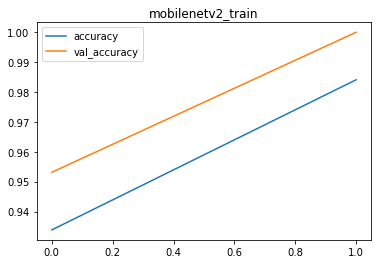

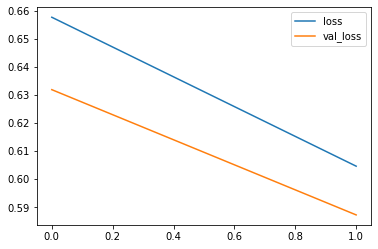

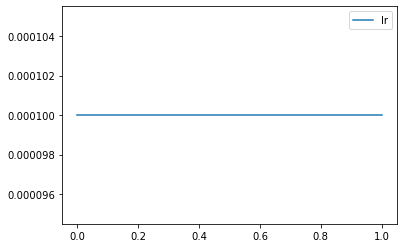

In [27]:
histories['mobilenetv2_train'] = compilefit(mobilenetv2_train,'cnn/mobilenetv2_train')
plotdf(histories['mobilenetv2_train'].history,'mobilenetv2_train')
results = mobilenetv2_train.evaluate(test_ds,steps=TEST_STEPS)
print('test loss, test acc:', results)
#80

In [28]:
inputs = tf.keras.Input(shape=(100,100,3))
y1 = model_cnnA(inputs)
y2 = model_cnnB(inputs)
y3 = mobilenetv2(inputs)
y4 = mobilenetv2_train(inputs)
y5 = average([y1,y2,y3,y4]) #choose models to ensemble
# y5 = maximum([y1,y2,y3,y4])
outputs = tf.keras.layers.Softmax()(y5)
ensemble_model = tf.keras.Model(inputs=inputs, outputs=outputs)
ensemble_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])
results = ensemble_model.evaluate(test_ds,steps=TEST_STEPS)
print('test loss, test acc:', results)

27/27 [==============================] - 5s 198ms/step - loss: 1.3430 - accuracy: 0.4549

In [29]:
def load_dataset(dataset_dir):
    dataset_dir = pathlib.Path(dataset_dir)
    test_image_count2 = len(list(test_data_dir.glob('image\*.jpg')))
    list_ds = tf.data.Dataset.list_files(str(dataset_dir/'image/*.jpg'))
    for f in list_ds.take(5):
          print(f.numpy())
    labeled_ds = list_ds.map(read_and_label, num_parallel_calls=AUTOTUNE)
    return labeled_ds,test_image_count2

In [30]:
datasett,datasettsize = load_dataset(r'C:\Users\kuki\Desktop\Research\Skin\RCNN data\test\young\sec025')

b'C:\\Users\\kuki\\Desktop\\Research\\Skin\\RCNN data\\test\\young\\sec025\\image\\474.jpg'
b'C:\\Users\\kuki\\Desktop\\Research\\Skin\\RCNN data\\test\\young\\sec025\\image\\73.jpg'
b'C:\\Users\\kuki\\Desktop\\Research\\Skin\\RCNN data\\test\\young\\sec025\\image\\133.jpg'
b'C:\\Users\\kuki\\Desktop\\Research\\Skin\\RCNN data\\test\\young\\sec025\\image\\198.jpg'
b'C:\\Users\\kuki\\Desktop\\Research\\Skin\\RCNN data\\test\\young\\sec025\\image\\241.jpg'


In [ ]:
# plt.figure(figsize=(10,10))
# for idx,elem in enumerate(datasett.take(25)):
#     img = elem[0]
#     label = elem[1]
#     ax2 = plt.subplot(5,5,idx+1)
#     plt.imshow(img)
#     plt.title(CLASS_NAMES[label].title())
#     plt.axis('off')

In [31]:
results = model_cnnA.evaluate(datasett.batch(10000))
print('test loss, test acc:', results[-1]*100)


1/1 [==============================] - 2s 2s/step - loss: 1.8883 - accuracy: 0.0034
test loss, test acc: 0.3401360474526882


In [32]:
results = model_cnnB.evaluate(datasett.batch(10000))
print('test loss, test acc:', results[-1]*100)


1/1 [==============================] - 2s 2s/step - loss: 0.7862 - accuracy: 0.6667
test loss, test acc: 66.66666865348816


In [33]:
results = mobilenetv2.evaluate(datasett.batch(10000))
print('test loss, test acc:', results[-1]*100)


1/1 [==============================] - 3s 3s/step - loss: 0.9104 - accuracy: 0.2823
test loss, test acc: 28.231292963027954


In [34]:
results = mobilenetv2_train.evaluate(datasett.batch(10000))
print('test loss, test acc:', results[-1]*100)


1/1 [==============================] - 4s 4s/step - loss: 0.7354 - accuracy: 0.8639
test loss, test acc: 86.39456033706665


In [35]:
results2 = ensemble_model.evaluate(datasett.batch(10000))
print('test loss, test acc:', results2[-1]*100)


1/1 [==============================] - 6s 6s/step - loss: 1.3046 - accuracy: 0.5374
test loss, test acc: 53.74149680137634
